,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,0,16.60,yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,0,20.34,no,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,0,26.58,yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,0,24.21,no,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,0,23.71,no,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


BMI                 0.000469
PhysicalHealth      0.000375
SleepTime           0.000313
HeartDisease        0.000000
Race                0.000000
KidneyDisease       0.000000
Asthma              0.000000
GenHealth           0.000000
PhysicalActivity    0.000000
Diabetic            0.000000
dtype: float64

HeartDisease          int64
BMI                 float64
Smoking              object
AlcoholDrinking      object
Stroke               object
PhysicalHealth      float64
MentalHealth        float64
DiffWalking          object
Sex                  object
AgeCategory          object
Race                 object
Diabetic             object
PhysicalActivity     object
GenHealth            object
SleepTime           float64
Asthma               object
KidneyDisease        object
SkinCancer           object
dtype: object
CV ROC-AUC: 0.844 ± 0.001
              precision    recall  f1-score   support

           0       0.92      0.99      0.96     58484
           1       0.60      0.08      0.15      5475

    accuracy                           0.92     63959
   macro avg       0.76      0.54      0.55     63959
weighted avg       0.89      0.92      0.89     63959

Test ROC-AUC: 0.83970352270566


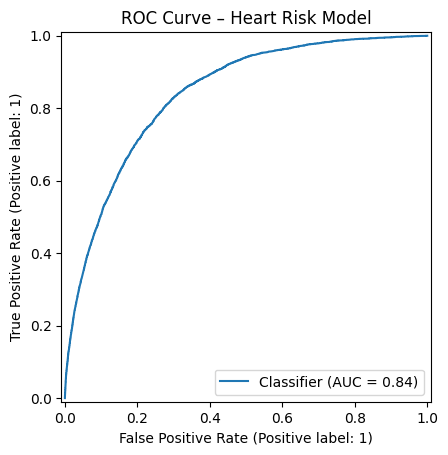

In [1]:
# 📦 Import required libraries
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import joblib, json

# ML preprocessing and modeling tools
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay
from xgboost import XGBClassifier

# 📥 Load and preprocess dataset
df = pd.read_csv('heart_2020_uncleaned.csv')

# 🔁 Convert target variable 'HeartDisease' to binary (Yes → 1, No → 0)
df['HeartDisease'] = df['HeartDisease'].map({'Yes': 1, 'No': 0})

# 🧪 Display sample and missing data summary
display(df.head())
display(df.isna().mean().sort_values(ascending=False).head(10))  # Show % missing
print(df.dtypes)

# 🎯 Define target and feature columns
target = 'HeartDisease'

# Numerical features (continuous health metrics)
num_feats = ['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']

# Categorical features (demographics, conditions, habits)
cat_feats = [
    'Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex',
    'AgeCategory', 'Race', 'Diabetic', 'PhysicalActivity',
    'GenHealth', 'Asthma', 'KidneyDisease', 'SkinCancer'
]

# 📊 Split data into training and testing sets (80/20) with stratified sampling
X_train, X_test, y_train, y_test = train_test_split(
    df[num_feats + cat_feats], df[target],
    test_size=0.2, stratify=df[target], random_state=42
)

# 🛠️ Define preprocessing pipelines
# For numeric features: fill missing values with median, then scale
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler())
])

# For categorical features: fill missing with most common, then one-hot encode
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine both pipelines into one using ColumnTransformer
preproc = ColumnTransformer([
    ('num', numeric_pipeline, num_feats),
    ('cat', categorical_pipeline, cat_feats)
])

# 🤖 Define and configure the XGBoost model
model = XGBClassifier(
    n_estimators=300,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    eval_metric='logloss'
)

# 🔗 Combine preprocessing and model into a single pipeline
pipe = Pipeline([
    ('pre', preproc),
    ('clf', model)
])

# 🔁 Evaluate model using 5-fold cross-validation and ROC AUC scoring
scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='roc_auc')
print(f'CV ROC-AUC: {scores.mean():.3f} ± {scores.std():.3f}')

# 📈 Fit model to full training set
pipe.fit(X_train, y_train)

# 🧪 Predict on test set
y_pred  = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]  # Probability of class 1 (At Risk)

# 📋 Show evaluation results
print(classification_report(y_test, y_pred))
print("Test ROC-AUC:", roc_auc_score(y_test, y_proba))

# 📊 Display ROC Curve
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title('ROC Curve – Heart Risk Model')
plt.show()

# 💾 Save trained pipeline for reuse in the Streamlit app
# This makes it easy to reload and predict in a different script (e.g., app.py)
joblib.dump(pipe, 'model_pipeline.pkl')

# 💾 Save feature metadata (needed by app.py to build the input form)
# This avoids hardcoding feature names and keeps the app consistent with the model
meta = {
    "num_feats": num_feats,
    "cat_feats": cat_feats,
    "target":    target
}
json.dump(meta, open('feature_metadata.json', 'w'))

In [2]:
# 📊 Automatically display summary after evaluation

print("\n" + "="*30)
print("📌 MODEL SUMMARY & EVALUATION")
print("="*30)

# ---- Missing Data ----
print("\n🧼 Missing Data (Top 10 Features):")
missing_summary = df.isna().mean().sort_values(ascending=False).head(10)
print(missing_summary)

# ---- Data Types ----
print("\n🧬 Feature Data Types:")
print(df.dtypes)

# ---- Cross-Validation AUC ----
print(f"\n🎯 Cross-Validated ROC-AUC: {scores.mean():.3f} ± {scores.std():.3f}")

# ---- Classification Report ----
print("\n📋 Classification Report on Test Set:")
print(classification_report(y_test, y_pred))

# ---- Test ROC-AUC ----
test_auc = roc_auc_score(y_test, y_proba)
print(f"\n📈 Test ROC-AUC: {test_auc:.4f}")

# ---- Interpretation ----
print("\n💡 Interpretation:")
print("- Model performs very well on the majority class (Not at Risk)")
print("- Recall for minority class (At Risk) is low due to class imbalance")
print("- AUC of ~0.84 shows good ranking capability")


📌 MODEL SUMMARY & EVALUATION

🧼 Missing Data (Top 10 Features):
BMI                 0.000469
PhysicalHealth      0.000375
SleepTime           0.000313
HeartDisease        0.000000
Race                0.000000
KidneyDisease       0.000000
Asthma              0.000000
GenHealth           0.000000
PhysicalActivity    0.000000
Diabetic            0.000000
dtype: float64

🧬 Feature Data Types:
HeartDisease          int64
BMI                 float64
Smoking              object
AlcoholDrinking      object
Stroke               object
PhysicalHealth      float64
MentalHealth        float64
DiffWalking          object
Sex                  object
AgeCategory          object
Race                 object
Diabetic             object
PhysicalActivity     object
GenHealth            object
SleepTime           float64
Asthma               object
KidneyDisease        object
SkinCancer           object
dtype: object

🎯 Cross-Validated ROC-AUC: 0.844 ± 0.001

📋 Classification Report on Test Set:
         